We need to transform text into something that machines can more readily analyze. Today we'll discuss vector representations such as bag of words and embedding models. We'll use those representations for search, visualization, and prepare for our classification day tomorrow.  
Processing for ml models often means translating the data from docs to a numerical format. BoW approaches (sometimes called frequency-based word embeddings) accomplish this by "vectorizing" tokenized docs. This is done by representing each doc as a row in a dataframe and creating a column for each unique word in the corpora (a group of docs). The presence or lack of a given word is then represented as either a count of how many times that word appears in a document or as that word's TF-IDF score.  
On the python side, we'll be focusing on sklearn and spacy today.

We're gonna pretend we're on the data science team at BBC. We want to recommend articles to visitors on the site based on the article they just read.  

# Learning objectives

Part 1: Represent a document as a vector  
Part 2: Query documents by similarity  
Part 3: Apply word embedding models to create document vectors.

In [16]:
# imports

# classics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import spacy
nlp = spacy.load("en_core_web_md")

In [2]:
# clone the git repo
!git clone https://github.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP.git

Cloning into 'DS-Unit-4-Sprint-1-NLP'...


In [3]:
import os 

def gather_data(filefolder):
    """ Produces List of Documents from a Directory
    
    filefolder (str): a path of .txt files
    
    returns list of strings 
    """
    
    data = []
    
    files = os.listdir(filefolder) # Causes variation across machines
    
    for filename in files: 
        
        path = os.path.join(filefolder, filename)
                    
        if  path[-3:] == 'txt': # os ~endswith('txt')
            with open(path, 'rb') as f:
                data.append(f.read())
    
    return data

In [6]:
# locate and get path to the /data folder, using colab's file browser
data_path = 'data'
data = gather_data(data_path)

In [7]:
print(type(data))
print(len(data))

<class 'list'>
401


In [8]:
# articles turn out to be byte strings, so we need to decode them to strings
print(data[20])
print(type(data[20]))

b'Britons fed up with net service\r\n\r\nA survey conducted by PC Pro Magazine has revealed that many Britons are unhappy with their internet service.\r\n\r\nThey are fed up with slow speeds, high prices and the level of customer service they receive. 17% of readers have switched suppliers and a further 16% are considering changing in the near future. It is particularly bad news for BT, the UK\'s biggest internet supplier, with almost three times as many people trying to leave as joining.\r\n\r\nA third of the 2,000 broadband users interviewed were fed up with their current providers but this could be just the tip of the iceberg thinks Tim Danton, editor of PC Pro Magazine. "We expect these figures to leap in 2005. Every month the prices drop, and more and more people are trying to switch," he said. The survey found that BT and Tiscali have been actively dissuading customers from leaving by offering them a lower price when they phone up to cancel their subscription. Some readers were o

In [9]:
# decode bytestrings in a corpus to strings
# takes a list of documents, i.e a list of strings as input
articles = []
for article in data:
  article = article.decode("utf-8")
  articles.append(article)
print(len(articles))

data = articles

401


In [10]:
print(data[20])
print(type(data[20]))

Britons fed up with net service

A survey conducted by PC Pro Magazine has revealed that many Britons are unhappy with their internet service.

They are fed up with slow speeds, high prices and the level of customer service they receive. 17% of readers have switched suppliers and a further 16% are considering changing in the near future. It is particularly bad news for BT, the UK's biggest internet supplier, with almost three times as many people trying to leave as joining.

A third of the 2,000 broadband users interviewed were fed up with their current providers but this could be just the tip of the iceberg thinks Tim Danton, editor of PC Pro Magazine. "We expect these figures to leap in 2005. Every month the prices drop, and more and more people are trying to switch," he said. The survey found that BT and Tiscali have been actively dissuading customers from leaving by offering them a lower price when they phone up to cancel their subscription. Some readers were offered a price drop j

In [24]:
# make a spacy tokenizer for the text data
def tokenize(document):
    '''Takes a doc (string) and returns a list of tokens in the form of lemmas.
    Filters out stop words, punctuation, and leading/trailing spaces.'''
    doc = nlp(document)
    # last "and" statement is to remove token lemmas that are empty strings
    # .strip() removes leading and trailing spaces
    lemma_list = [token.lemma_.lower().strip() for token in doc if (not token.is_stop) and (not token.is_punct) and (token.lemma_.strip() != "")]
    return lemma_list

In [25]:
data[20]

'Britons fed up with net service\r\n\r\nA survey conducted by PC Pro Magazine has revealed that many Britons are unhappy with their internet service.\r\n\r\nThey are fed up with slow speeds, high prices and the level of customer service they receive. 17% of readers have switched suppliers and a further 16% are considering changing in the near future. It is particularly bad news for BT, the UK\'s biggest internet supplier, with almost three times as many people trying to leave as joining.\r\n\r\nA third of the 2,000 broadband users interviewed were fed up with their current providers but this could be just the tip of the iceberg thinks Tim Danton, editor of PC Pro Magazine. "We expect these figures to leap in 2005. Every month the prices drop, and more and more people are trying to switch," he said. The survey found that BT and Tiscali have been actively dissuading customers from leaving by offering them a lower price when they phone up to cancel their subscription. Some readers were of

In [26]:
tokenize(data[20])

['britons',
 'feed',
 'net',
 'service',
 'survey',
 'conduct',
 'pc',
 'pro',
 'magazine',
 'reveal',
 'britons',
 'unhappy',
 'internet',
 'service',
 'feed',
 'slow',
 'speed',
 'high',
 'price',
 'level',
 'customer',
 'service',
 'receive',
 '17',
 'reader',
 'switch',
 'supplier',
 '16',
 'consider',
 'change',
 'near',
 'future',
 'particularly',
 'bad',
 'news',
 'bt',
 'uk',
 'big',
 'internet',
 'supplier',
 'time',
 'people',
 'try',
 'leave',
 'join',
 '2,000',
 'broadband',
 'user',
 'interview',
 'feed',
 'current',
 'provider',
 'tip',
 'iceberg',
 'think',
 'tim',
 'danton',
 'editor',
 'pc',
 'pro',
 'magazine',
 'expect',
 'figure',
 'leap',
 '2005',
 'month',
 'price',
 'drop',
 'people',
 'try',
 'switch',
 'say',
 'survey',
 'find',
 'bt',
 'tiscali',
 'actively',
 'dissuade',
 'customer',
 'leave',
 'offer',
 'low',
 'price',
 'phone',
 'cancel',
 'subscription',
 'reader',
 'offer',
 'price',
 'drop',
 '25p',
 'expensive',
 'offer',
 'alternative',
 'operator',
 

# Represent a document as a vector (Learn)

In this section, we make document term matrices (dtm).  
In the dtm, each row represents a doc, and the columns correspond to the vocab words of the entire corpus of documents.  
Today, we'll learn three methods of computing the value in each cell.  
- CountVectorizer from sklearn provides a basic implementation in that it just counts the appearances of words. You can also ignore multiple occurences of words in a doc, and just keep track of whether or not a word occurs in the doc via a boolean value.  
- TfidfVectorizer is a more advanced implementation that keeps track of term-frequency inverse-document frequency instead of integer counts.  
- Word embeddings, an even more advanced implementation that helps solve the problem of accounting for the context of a word.  

# Follow along

Extract the tokens from this sentence using Spacy.

In [32]:
text = """GPT-2 displays a broad set of capabilities, including the ability to generate conditional synthetic text samples of unprecedented quality, where we prime the model with an input and have it generate a lengthy continuation. In addition, GPT-2 outperforms other language models trained on specific domains (like Wikipedia, news, or books) without needing to use these domain-specific training datasets. On language tasks like question answering, reading comprehension, summarization, and translation, GPT-2 begins to learn these tasks from the raw text, using no task-specific training data. While scores on these downstream tasks are far from state-of-the-art, they suggest that the tasks can benefit from unsupervised techniques, given sufficient (unlabeled) data and compute."""

In [33]:
# fit the model to our text
doc = nlp(text)
tokens = []
tokens = [token.lemma_ for token in doc if (not token.is_stop) and (not token.is_punct)]
print(len(tokens))
tokens

73


['GPT-2',
 'display',
 'broad',
 'set',
 'capability',
 'include',
 'ability',
 'generate',
 'conditional',
 'synthetic',
 'text',
 'sample',
 'unprecedented',
 'quality',
 'prime',
 'model',
 'input',
 'generate',
 'lengthy',
 'continuation',
 'addition',
 'GPT-2',
 'outperform',
 'language',
 'model',
 'train',
 'specific',
 'domain',
 'like',
 'Wikipedia',
 'news',
 'book',
 'need',
 'use',
 'domain',
 'specific',
 'training',
 'dataset',
 'language',
 'task',
 'like',
 'question',
 'answer',
 'read',
 'comprehension',
 'summarization',
 'translation',
 'GPT-2',
 'begin',
 'learn',
 'task',
 'raw',
 'text',
 'task',
 'specific',
 'training',
 'datum',
 'score',
 'downstream',
 'task',
 'far',
 'state',
 'art',
 'suggest',
 'task',
 'benefit',
 'unsupervised',
 'technique',
 'give',
 'sufficient',
 'unlabeled',
 'datum',
 'compute']

# CountVectorizer

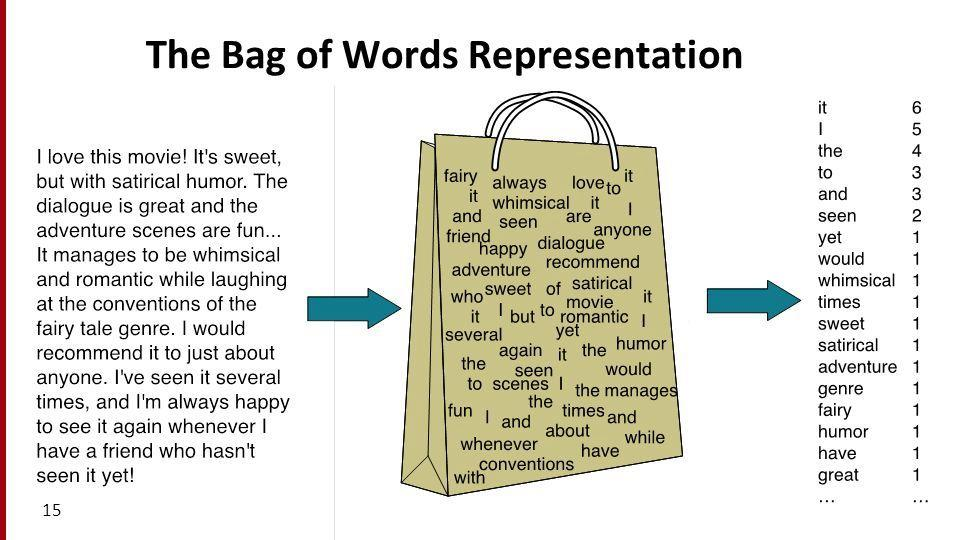

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
# list of text docs
# create the transformer
# build vocab
# transform text
### begin solution
# a corpus is a selection of docs
corpus = ["We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.",
          " In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.",
          " This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl."]
# create the transformer
vect = CountVectorizer()
# build vocab by fitting the transformer
vect.fit(corpus)
# transform text to create the document-term matrix
dtm = vect.transform(corpus)
### end solution

In [35]:
dtm

<3x61 sparse matrix of type '<class 'numpy.int64'>'
	with 69 stored elements in Compressed Sparse Row format>

In [36]:
# explore the dtm
# get feature names
# print out raw text for comparison with indexing
# show indexing of token count
# dealing with sparse matrix
# get word counts for each document
### BEGIN SOLUTION
# get feature names --- this is the vocabulary for the corpus
print(vect.get_feature_names())
print(len(vect.get_feature_names()))

['as', 'at', 'be', 'been', 'by', 'can', 'commoncrawl', 'content', 'created', 'curated', 'data', 'dataset', 'datasets', 'diversity', 'document', 'educational', 'emphasizes', 'filtered', 'for', 'found', 'from', 'funny', 'have', 'heuristic', 'higher', 'humans', 'in', 'indicator', 'interesting', 'internet', 'karma', 'leading', 'least', 'link', 'links', 'new', 'of', 'only', 'or', 'order', 'other', 'outbound', 'pages', 'preserve', 'quality', 'received', 'reddit', 'scraping', 'similar', 'specifically', 'such', 'than', 'the', 'this', 'thought', 'to', 'used', 'users', 'we', 'whether', 'which']
61


In [37]:
# print out raw text for comparison with indexing
print(corpus)

['We created a new dataset which emphasizes diversity of content, by scraping content from the Internet.', ' In order to preserve document quality, we used only pages which have been curated/filtered by humans—specifically, we used outbound links from Reddit which received at least 3 karma.', ' This can be thought of as a heuristic indicator for whether other users found the link interesting (whether educational or funny), leading to higher data quality than other similar datasets, such as CommonCrawl.']


In [38]:
# show indexing of token count
print(dtm)
print(type(dtm))

  (0, 4)	1
  (0, 7)	2
  (0, 8)	1
  (0, 11)	1
  (0, 13)	1
  (0, 16)	1
  (0, 20)	1
  (0, 29)	1
  (0, 35)	1
  (0, 36)	1
  (0, 47)	1
  (0, 52)	1
  (0, 58)	1
  (0, 60)	1
  (1, 1)	1
  (1, 3)	1
  (1, 4)	1
  (1, 9)	1
  (1, 14)	1
  (1, 17)	1
  (1, 20)	1
  (1, 22)	1
  (1, 25)	1
  (1, 26)	1
  (1, 30)	1
  :	:
  (2, 10)	1
  (2, 12)	1
  (2, 15)	1
  (2, 18)	1
  (2, 19)	1
  (2, 21)	1
  (2, 23)	1
  (2, 24)	1
  (2, 27)	1
  (2, 28)	1
  (2, 31)	1
  (2, 33)	1
  (2, 36)	1
  (2, 38)	1
  (2, 40)	2
  (2, 44)	1
  (2, 48)	1
  (2, 50)	1
  (2, 51)	1
  (2, 52)	1
  (2, 53)	1
  (2, 54)	1
  (2, 55)	1
  (2, 57)	1
  (2, 59)	2
<class 'scipy.sparse.csr.csr_matrix'>


DTM is a sparse matrix, so next we convert it into a dense matrix.

In [39]:
from scipy import sparse as sparse

In [46]:
# Dealing with Sparse Matrix
dtm_dense_matrix = dtm.todense()

In [47]:
dtm_dense_matrix

matrix([[0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
        [0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
         0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 2, 0, 2, 0, 2],
        [2, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0,
         1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 2, 0,
         0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 2, 0]],
       dtype=int64)

In [48]:
# get word counts for each document
dtm_new = pd.DataFrame(dtm_dense_matrix, columns = vect.get_feature_names())
dtm_new

,as,at,be,been,by,can,commoncrawl,content,created,curated,...,than,the,this,thought,to,used,users,we,whether,which
0,0,0,0,0,1,0,0,2,1,0,...,0,1,0,0,0,0,0,1,0,1
1,0,1,0,1,1,0,0,0,0,1,...,0,0,0,0,1,2,0,2,0,2
2,2,0,1,0,0,1,1,0,0,0,...,1,1,1,1,1,0,1,0,2,0


# Challenge

In [49]:
# apply countvectorizer to our data
# use custom spacy vectorizer
# bbc articles in "data" variable
from sklearn.feature_extraction.text import CountVectorizer
# learn our vocab
# get sparse dtm (i.e transform the data)
### BEGIN SOLUTION 
vect = CountVectorizer(stop_words = "english", max_features = 1000)
# learn our vocab
vect.fit(data)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1000, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [52]:
# Get sparse dtm -- `vect.transform() produces a sparse matrix output,
# so we have to transform it back to a dense matrix and create a data frame!
dtm = pd.DataFrame(vect.transform(data).todense())
dtm

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,2,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,2,0,0,0,0,0,1,2,...,0,0,0,0,0,0,0,2,3,0
4,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
397,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
398,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,2,0,0
399,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0


In [53]:
dtm.shape

(401, 1000)

In [54]:
type(data[0])

str

In [55]:
len(data[0])

4063

In [56]:
# list of document lengths measured by num of characters in document
doc_len = [len(doc) for doc in data]

<AxesSubplot:>

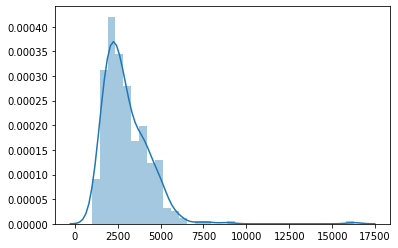

In [57]:
import seaborn as sns
sns.distplot(doc_len)

# TfidfVectorizer

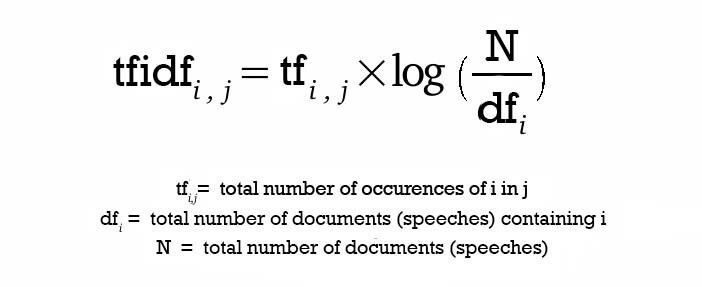

Term Frequency: tfi,j is the number of times term i appeared in doc j.  
Inverse Doc Frequency: A weight penalty for terms that exist in a high  
fraction of documents.  
The purpose of tfidf is to find what is unique to each document. Because of this we penalize the term frequencies of words that are common across all docs. In practice this upweights rarer terms across docs.  
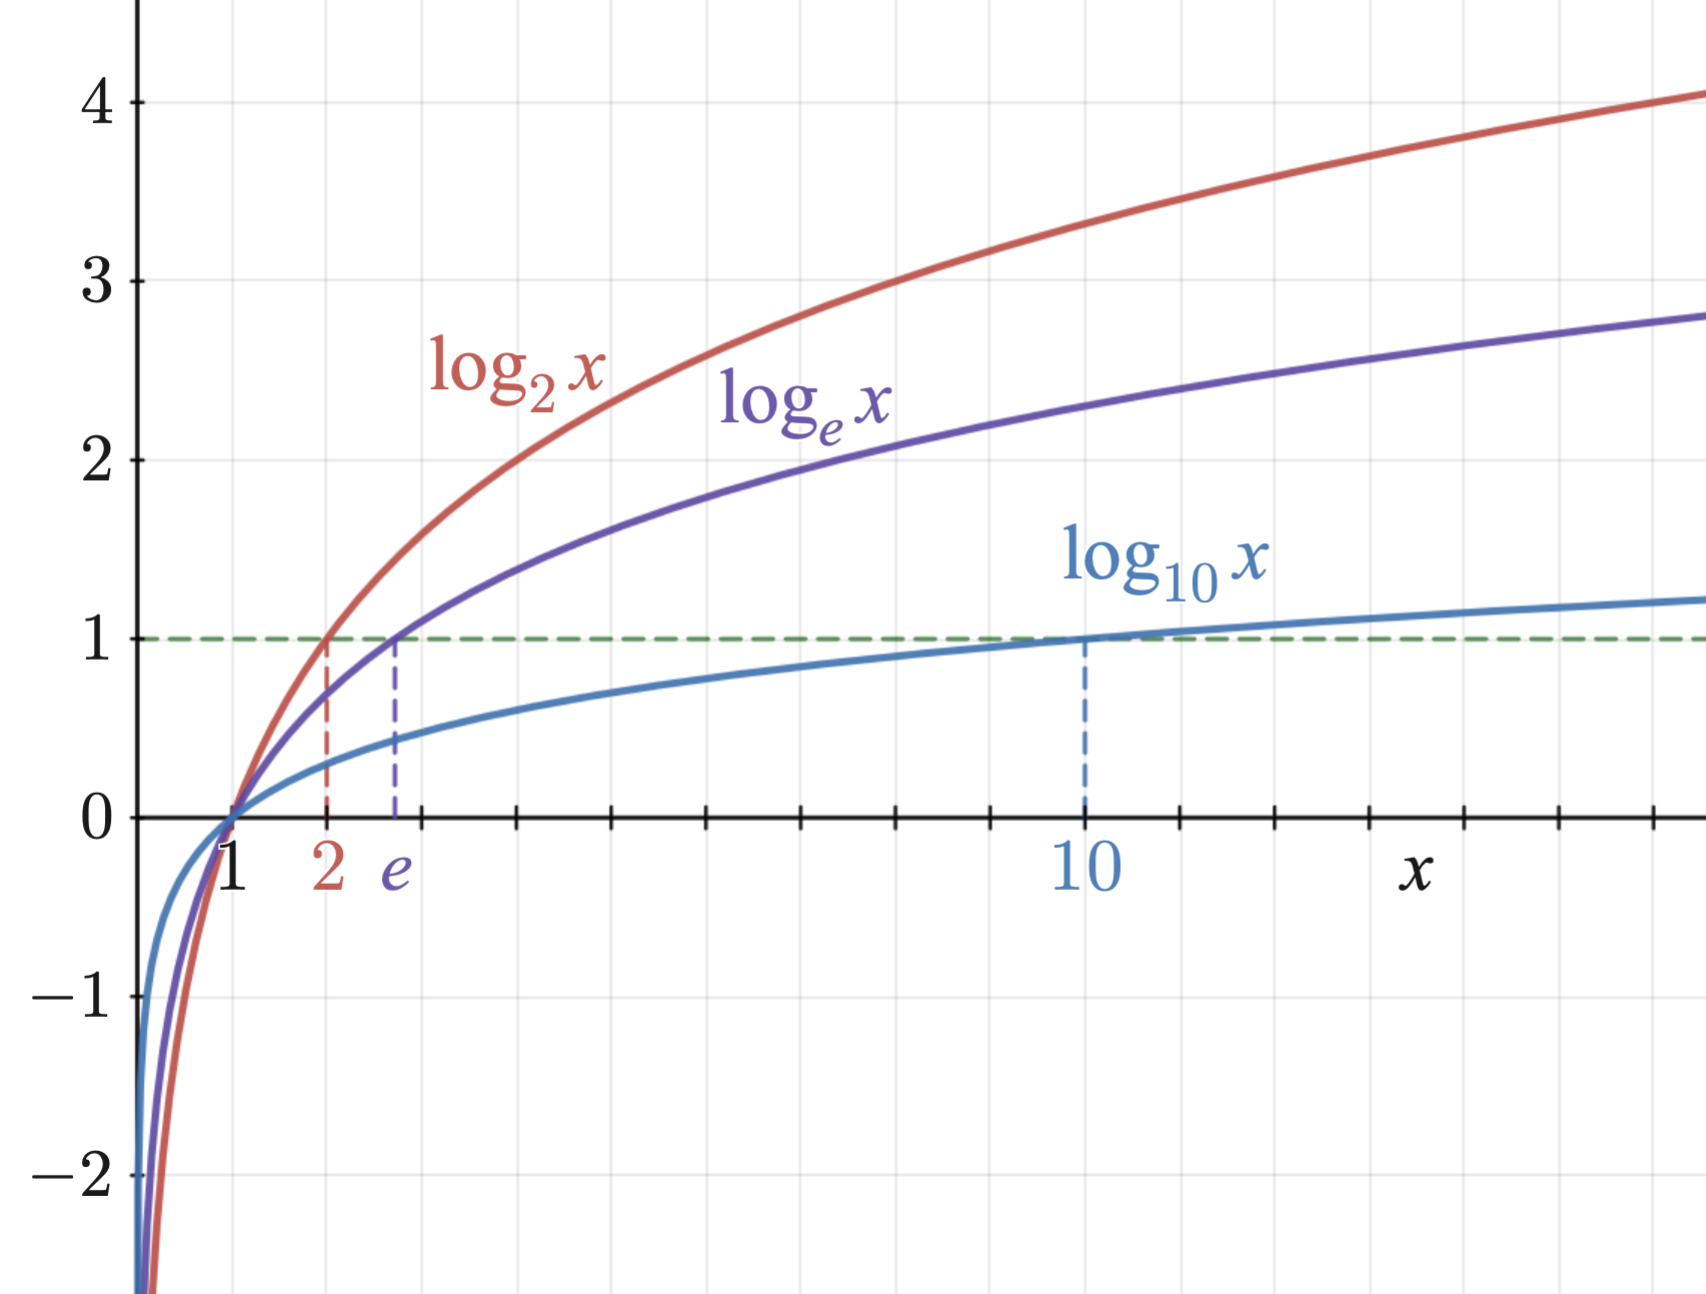

It's useful to reference both the algebraic and geometric representations of a single mathematical ideal whenever possible in order to build the fullest understanding possible.  
The idf portion has been coded above so that we can play around with the values and get a better understanding of how that portion of the equation works.  

In [64]:
# inverse document frequency score 
# the plus ones are constants that shift the around the baseline value 
def idf(n, df):
    """
    Parameters
    ----------
    n: int
        num of docs in corpus 
        
    df: int
        num of docs that term t (i.e. a token) appears in 

    Returns
    -------
    inverse docuemnt frequency: float
    """
    return np.log( n/ df) 

In [65]:
###BEGIN SOLUTION
n = 100 # num of docs in corpus 
df_range = 100
IDF = []
DF = []
for df in range(1, df_range + 1):
    idf_score = idf(n, df)
    IDF.append(idf_score)
    DF.append(df)
###END SOLUTION

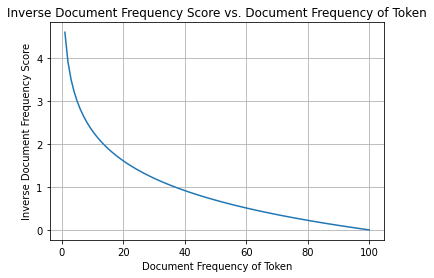

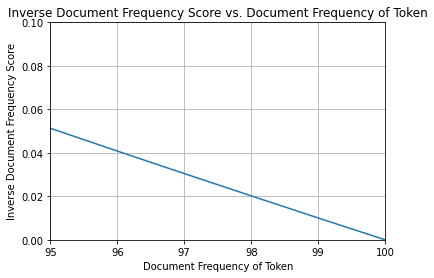

In [66]:
plt.figure()
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.grid()
plt.plot(DF, IDF);
plt.show()

plt.figure()
plt.title("Inverse Document Frequency Score vs. Document Frequency of Token")
plt.ylabel("Inverse Document Frequency Score")
plt.xlabel("Document Frequency of Token")
plt.xlim(95,100)
plt.ylim(0,0.10)
plt.grid()
plt.plot(DF, IDF);
plt.show()

In [68]:
# let's work through a couple of examples to help build intuition 

# imagine the token we are considering is "purchase", which rarely appears

# imagine the token that we are considering is "the", which appears often


###BEGIN SOLUTION
n = 100 # num of docs in corpus

# imagine the token we are considering is "purchase"
tf = 1
df = 20

tfidf_score = tf * idf(n, df)
print(f'purchase: {tfidf_score:.2f}')

###END SOLUTION
# imagine the token that we are considering is "the"
tf = 50
df = 95

tfidf_score = tf * idf(n, df)
print(f'the: {tfidf_score:.2f}')
###END SOLUTION

purchase: 1.61
the: 2.56


Now that we have some intuition on how tfidf works, let's use sklearn's tfidf vectorizer to vectorize our dataset.  
Note that tfidfvectorizer is used with the same syntax as countvectorizer.

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
### BEGIN SOLUTION
# instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = "english", max_features = 1000)
# create a vocabulary and get word counts per doc
dtm = tfidf.fit_transform(data)
# view term-document matrix as a dataframe
dtm = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())
dtm.head()

,000,10,100,11,12,14,15,18,20,200,...,worldwide,worm,worth,writing,xbox,xp,yahoo,year,years,york
0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.035049,0.0,0.050637,0.0,0.103277,0.0,0.000000,0.0,0.000000,0.057829,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
2,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
3,0.000000,0.0,0.113634,0.0,0.000000,0.0,0.000000,0.0,0.055417,0.129775,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064479,0.126203,0.0
4,0.000000,0.0,0.033050,0.0,0.000000,0.0,0.034399,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037507,0.024470,0.0


To get fancier with the Tfidf vectorizer, we'll use some additional keywords to do the following:  
- Build a vocabulary from unigrams and bigrams  
- Do statistical trimming by ignoring terms with a frequency higher than max_df and all terms with a doc frequency lower than min_df  
- Use the spaCy tokenizer that we built.

In [74]:
%%time
# tuning parameters
# instantiate vectorizer object
# create a vocab and get word counts per doc
# print word counts
# get feature names to use as dataframe column headers
# view feature matrix as dataframe
### BEGIN SOLUTION
# instantiate vector object (ngram_range includes unigrams and bigrams)
tfidf = TfidfVectorizer(ngram_range=(1, 2),
                       max_df = .97, # statistical trimming
                       min_df = .03,
                       tokenizer = tokenize)
# create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(data) # similar to fit_predict-- makes sparse matrix
# print word counts
# get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns = tfidf.get_feature_names())

Wall time: 21 s


In [75]:
tfidf.get_feature_names()

['$',
 '1',
 '1,000',
 '10',
 '100',
 '100,000',
 '11',
 '12',
 '12 month',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '18 month',
 '2',
 '2,000',
 '20',
 '200',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '22',
 '24',
 '25',
 '28',
 '29',
 '3',
 '3 g',
 '30',
 '3d',
 '4',
 '40',
 '5',
 '50',
 '50,000',
 '6',
 '60',
 '80',
 '9',
 '90',
 '95',
 'ability',
 'able',
 'accept',
 'access',
 'accord',
 'accord report',
 'account',
 'achieve',
 'act',
 'action',
 'activity',
 'actually',
 'ad',
 'adapt',
 'add',
 'address',
 'admit',
 'adopt',
 'adult',
 'advance',
 'advanced',
 'advantage',
 'advert',
 'affect',
 'age',
 'agency',
 'ago',
 'agree',
 'ahead',
 'aid',
 'aim',
 'air',
 'alert',
 'allow',
 'allow people',
 'alongside',
 'america',
 'american',
 'amount',
 'analysis',
 'analyst',
 'andrew',
 'announce',
 'announcement',
 'annual',
 'anti',
 'anti virus',
 'aol',
 'appeal',
 'appear',
 'apple',
 'apple ipod',
 'application',
 'apply',
 'approach',
 'april',
 'a

In [76]:
dtm.head()

,$,1,"1,000",10,100,"100,000",11,12,12 month,13,...,writer,xbox,xp,yahoo,year,year ago,year say,york,young,£
0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000
1,0.000000,0.0,0.0,0.0,0.000000,0.07216,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.126467,0.000000
2,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0000,0.0,0.0,0.000000,0.000000
3,0.123712,0.0,0.0,0.0,0.050015,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.115315,0.0561,0.0,0.0,0.000000,0.036497
4,0.000000,0.0,0.0,0.0,0.033713,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.046637,0.0000,0.0,0.0,0.000000,0.024601


# Query documents by similarity (Learn)

While there are many different mechanisms for the 'match', one of the most classic is to search by similarity. We will apply two measures of similarity between a document and the input query document: the Cosine Similarity between the documents and the Euclidean distance between the documents.

Cosine similarity and nearest-neighbor distance provide two measures that can be used to gauge the similarity of one word to another.
We develop these concepts in this section.

The cosine similarity between two feature vectors is the dot product of the normalized feature vectors. To normalize a vector, you simply divide by its length. 
The larger the cosine similarity, the more similar the words are, and vice-versa.  
cosine_similarity takes as input the document_term matrix and creates a similarity matrix in which the rows and columns represent documents and entry (i, j) is the cosine similarity between documents i and j.  
Let's compute the similarity matrix for the BBC tech articles corpus.

In [77]:
%%time
from sklearn.metrics.pairwise import cosine_similarity
# calculate distance of tfidf vectors
# turn it into a dataframe
# our similarity matrix is ? size
# each row is the similarity of one doc to all others (including itself)
# grab the row and pick off the indices of the most/least similar docs
### BEGIN SOLUTION
# calculate distance of tfidf vectors
# similarity matrix
dist_matrix = cosine_similarity(dtm)
# turn it into a dataframe
df = pd.DataFrame(dist_matrix)
# size of the similarity matrix
print(df.shape)

(401, 401)
Wall time: 9 ms


In [78]:
print(np.min(dist_matrix))
print(np.max(dist_matrix))

0.0
1.0000000000000007


In [79]:
# each row is the similarity of one doc to all others
df.iloc[0]

0      1.000000
1      0.140123
2      0.042748
3      0.064215
4      0.068164
         ...   
396    0.032688
397    0.049264
398    0.102526
399    0.057923
400    0.103554
Name: 0, Length: 401, dtype: float64

# Find the most similar documents to the first

In [80]:
# grab the first row and return the indices of the 6 most similar docs
print(df[0].sort_values(ascending = False)[:6])
### END SOLUTION

0      1.000000
18     0.221521
328    0.215002
274    0.211688
190    0.146955
198    0.140955
Name: 0, dtype: float64


# K nearest neighbors search (KNN)

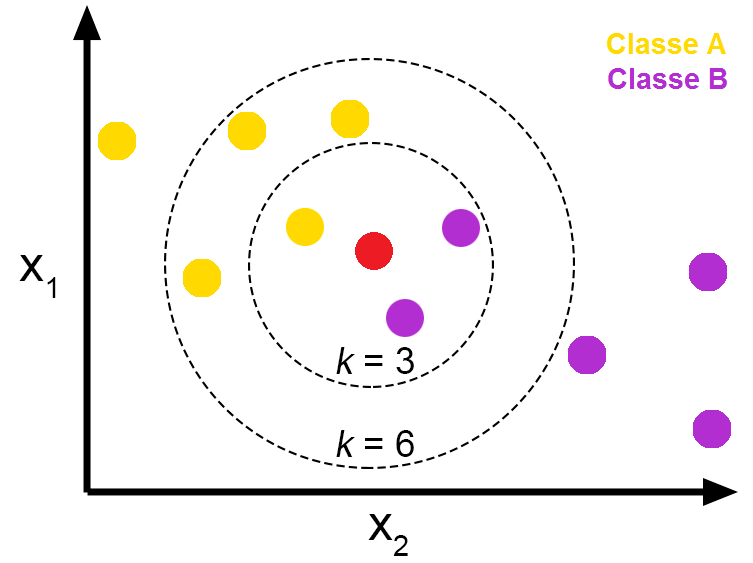  
nearest neighbor models are distance based algorithms. They store your training set in memory.
It computes distances between all pairs of data points, returns the result in the form of a similarity matrix, and entry(i, j) in the matrix records the similarity of data points i and j.  
Below is an example using NearestNeighbors to find the most similar documents to a given document.

In [81]:
%%time
from sklearn.neighbors import NearestNeighbors
# instantiate the nearest neighbors model
nn = NearestNeighbors()
# fit to our document term matrix
nn.fit(dtm.values)

Wall time: 49 ms


NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [82]:
# sample a doc from a dtm to use as our query point
doc_index = 0
query_doc = dtm.values[0][None, :]# recast as row vector;
# NOTE: nn counts the original document as one of the neighbors, so if we want
# 5 nearest neighbors, we should set n_neightbors=6
neigh_dist, neigh_index = nn.kneighbors(query_doc, n_neighbors = 6)

In [83]:
# nearest neighbor search returns the same documents as cosine similarity!
print(neigh_index)
print(neigh_dist)

[[  0  18 328 274 190 198]]
[[0.         1.24778118 1.25299471 1.25563661 1.30617397 1.31075912]]


# Apply word embedding models to create document vectors (Learn)

## Overview

Bag of Words (BoW) models lose information about context
One of the limitations of Bag-of-Words approaches is that any information about the context surrounding that word is lost. This also means that with bag-of-words approaches often the only tools that we have for identifying words with similar usage or meaning and subsequently consolidating them into a single vector is through the processes of stemming and lemmatization which tend to be quite limited at consolidating words unless the two words are very close in their spelling or in their root parts-of-speech.

Embedding approaches preserve more textual context
Word2Vec is an increasingly popular word embedding technique. Like Bag-of-words it learns a real-value vector representation for a predefined fixed-size vocabulary that is generated from a corpus of text. However, in contrast to BoW, Word2Vec approaches are much more capable of accounting for textual context, and are better at discovering words with similar meanings or usages (semantic or syntactic similarity).

SpaCy provides pretrained Word2Vec models.

We will use their en_core_web_md model, which has 300-dimensionall word embeddings for 20,000 words.

In [84]:
# process a text
nlp = spacy.load("en_core_web_md")
### BEGIN SOLUTION
doc = nlp("bananas")
# get the vector for the token bananas
bananas_vector = doc.vector
# 300-dim vector
print(len(bananas_vector))
print(bananas_vector)

300
[-2.2009e-01 -3.0322e-02 -7.9859e-02 -4.6279e-01 -3.8600e-01  3.6962e-01
 -7.7178e-01 -1.1529e-01  3.3601e-02  5.6573e-01 -2.4001e-01  4.1833e-01
  1.5049e-01  3.5621e-01 -2.1508e-01 -4.2743e-01  8.1400e-02  3.3916e-01
  2.1637e-01  1.4792e-01  4.5811e-01  2.0966e-01 -3.5706e-01  2.3800e-01
  2.7971e-02 -8.4538e-01  4.1917e-01 -3.9181e-01  4.0434e-04 -1.0662e+00
  1.4591e-01  1.4643e-03  5.1277e-01  2.6072e-01  8.3785e-02  3.0340e-01
  1.8579e-01  5.9999e-02 -4.0270e-01  5.0888e-01 -1.1358e-01 -2.8854e-01
 -2.7068e-01  1.1017e-02 -2.2217e-01  6.9076e-01  3.6459e-02  3.0394e-01
  5.6989e-02  2.2733e-01 -9.9473e-02  1.5165e-01  1.3540e-01 -2.4965e-01
  9.8078e-01 -8.0492e-01  1.9326e-01  3.1128e-01  5.5390e-02 -4.2423e-01
 -1.4082e-02  1.2708e-01  1.8868e-01  5.9777e-02 -2.2215e-01 -8.3950e-01
  9.1987e-02  1.0180e-01 -3.1299e-01  5.5083e-01 -3.0717e-01  4.4201e-01
  1.2666e-01  3.7643e-01  3.2333e-01  9.5673e-02  2.5083e-01 -6.4049e-02
  4.2143e-01 -1.9375e-01  3.8026e-01  7.0883e-0

# Spacy Document Vectors

From spacy we can get word2vec embeddings for each word in a document.  
We can create a document vector by averaging all the word vectors in that doc  
We can calculate the similarity between documents now.

In [85]:
doc1 = nlp("On a hot summer day, it's good to drink water.")
doc2 = nlp("There are lots of cold drinks in the refrigerator.")
doc3 = nlp("cosine distance measures similarity")

In [86]:
len(doc1.vector)

300

In [87]:
type(doc)

spacy.tokens.doc.Doc

In [88]:
### BEGIN SOLUTION
# get the similarity of doc1 and doc2
similarity = doc1.similarity(doc2)
print(similarity)
### END SOLUTION

0.8838439897643992


In [89]:
doc3.similarity(doc2)

0.3532817580631088

In [90]:
doc3.similarity(doc1)

0.3225841257225828

# Can we visualize word vectors?

We can't visualize 300 dimensional vectors. However, we can use principal components analysis (pca) to reduce their dimensionality.  
PCA is one of the most important techniques in machine learning, as well as mathematics. PCA transforms vectors of a dataset to their principal components, which are ranked in order of their importance in describing the dataset. By eliminating the less important components, we reduce dimensionality at the cost of some information.  

In [91]:
# import the pca module from sklearn
from sklearn.decomposition import PCA
def get_word_vectors(words):
    # converts a list of words to their word vectors
    return [nlp(word).vector for word in words]
words = ['machine learning', 'man', 'woman',  'king', 'queen',
         'artificial intelligence', 'nurse', 'doctor', 
         'data', 'science', 
         'concrete', 'wood', 
         'marble', 'design',
         'color', 'font']
word_vectors = get_word_vectors(words)
# initialize pca model and tell it to project data down to 2 dimensions.
# fit the model to our 33d data, this will work out which is the best way to
# project the data down that will best maintain the relative distances
# between data points. It will store these instructions on how to transform
# the data.
# tell our fitted model to transform our 300d data down to 2d using the
# instructions it learned during the fit phase.  
### BEGIN SOLUTION
# initialize model and tell it to project data down to 2d
pca = PCA(n_components = 2)
# fit the model to our data
pca.fit(word_vectors)
word_vecs_2d = pca.transform(word_vectors)
word_vecs_2d
### END SOLUTION

array([[-0.41618712,  1.26197946],
       [ 2.18589198, -0.71261883],
       [ 3.31224199, -0.63002031],
       [ 1.59658923, -3.92203056],
       [ 1.85318628, -3.63087635],
       [-0.44013359,  1.74871011],
       [ 4.43418803,  1.1308269 ],
       [ 3.83412466,  1.27867761],
       [-1.18444862,  4.02456793],
       [ 0.29446239,  2.77555674],
       [-2.87613195, -0.30775046],
       [-2.84180888, -2.66241824],
       [-3.03420388, -3.43600248],
       [-2.43581889,  1.23093633],
       [-2.24288034,  0.69948326],
       [-2.03907129,  1.15097888]])

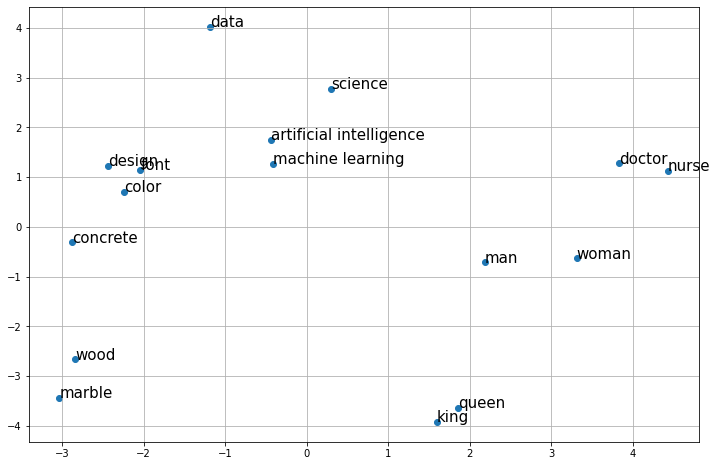

In [92]:
# create a plot
# create a nice big plot 
plt.figure(figsize=(12,8))

# plot the scatter plot of where the words will be
plt.scatter(word_vecs_2d[:,0], word_vecs_2d[:,1])

# for each word and coordinate pair: draw the text on the plot
for word, coord in zip(words, word_vecs_2d):
    x, y = coord
    plt.text(x, y, word, size= 15)

# show the plot
plt.grid();
plt.show()